In [2]:
import torch, pickle
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd


In [44]:
torch.cuda.empty_cache()
exp_dir   = "Trained_Models/2DCyl_Numobstest_ts10_2_localtest_deactivate_seqmodel"  #Experiment Directory
exp_name  = "sl8_nhu40_numobs2_bs16_lr5e-5"                #One of the experiment names

eval_mza = Eval_MZA(exp_dir, exp_name)
print(eval_mza.deactivate_seqmodel)

True


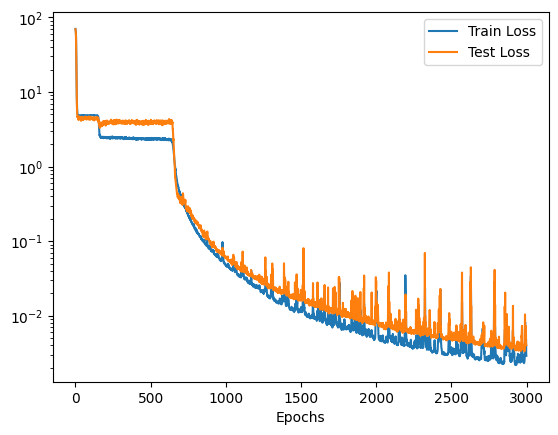

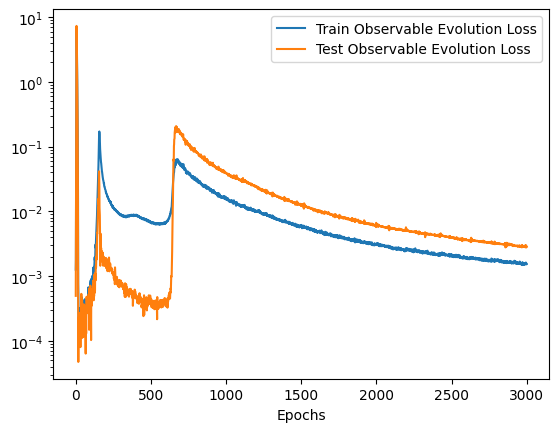

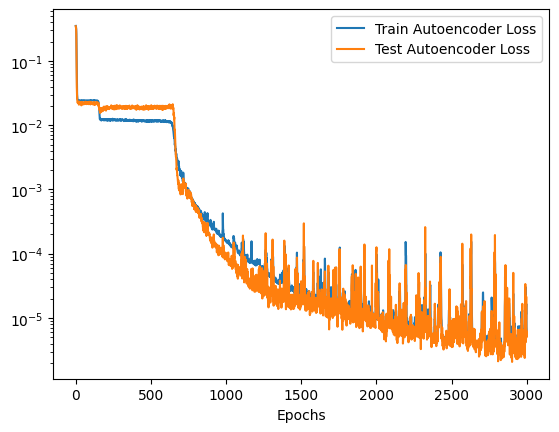

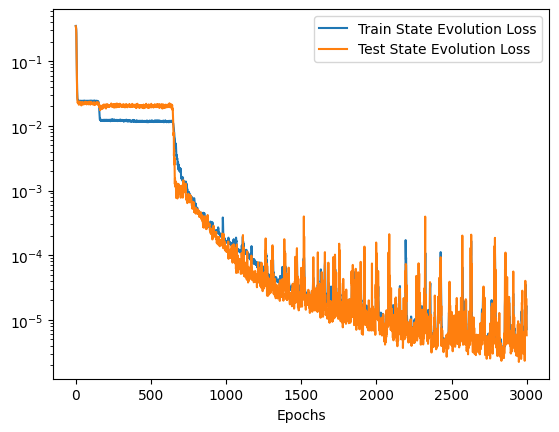

In [45]:
#plot learning curves
eval_mza.plot_learning_curves()

In [48]:
epoch_num = 2990
eval_mza.load_weights(epoch_num)

In [49]:
#One Step Prediction

# eval_mza.train_size = 0.9
eval_mza.load_and_preproc_data()
eval_mza.create_dataset(mode = "Train")
# del eval_mza.lp_data 
# torch.cuda.empty_cache()
# del eval_mza.train_dataset
# del eval_mza.train_dataloader
dataset = eval_mza.train_dataset
num_trajs = eval_mza.train_num_trajs

if not eval_mza.deactivate_seqmodel:
    x_nn_hat, Phi_nn_hat, Phi_nn, State_MSE, koop_out, seqmodel_out = eval_mza.predict_onestep(dataset, num_trajs)

else:
    x_nn_hat, Phi_nn_hat, Phi_nn, State_MSE = eval_mza.predict_onestep(dataset, num_trajs)
    
print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)

#Plotting one step prediction
x_nn_hat.shape


Data Shape:  (1, 201, 10108)
Not normalizing Input
Train_Shape:  (1, 198, 10108)
out of train
torch.Size([1, 198, 2]) torch.Size([1, 198, 10108]) torch.Size([1, 198, 10108])


torch.Size([1, 198, 2])

In [50]:
#Load Data
with open('Data/2DCylinder/cyl_data_10_2.pkl', 'rb') as f:
    data_dict = pickle.load(f)


In [51]:
sub_X = data_dict["sub_X"]
sub_Y = data_dict["sub_Y"]
U_nn = Phi_nn_hat[...,:int(Phi_nn_hat.shape[-1]/2)].detach().cpu().numpy()
V_nn = Phi_nn_hat[...,int(Phi_nn_hat.shape[-1]/2):].detach().cpu().numpy()
U = Phi_nn[...,:int(Phi_nn.shape[-1]/2)].detach().cpu().numpy()
V = Phi_nn[...,int(Phi_nn.shape[-1]/2):].detach().cpu().numpy()

U_nn.shape, V_nn.shape, U.shape, V.shape



((1, 198, 5054), (1, 198, 5054), (1, 198, 5054), (1, 198, 5054))

In [52]:
def energy(u,v):
    k = 0.5*(np.mean(u**2,axis=-1) + np.mean(v**2,axis=-1))
    return k

k_pred = energy(U_nn,V_nn)
k = energy(U, V)

(1, 198)


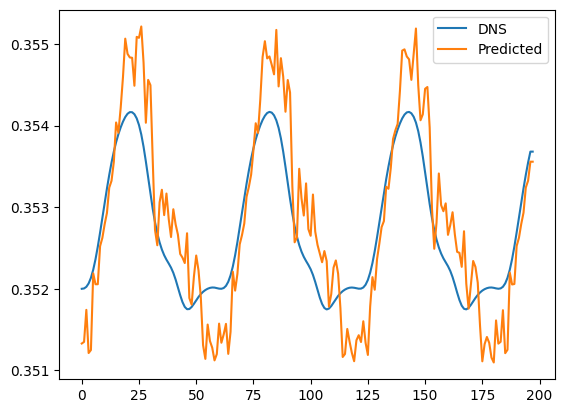

In [53]:
print(k.shape)
plt.plot(k[0,:], label = "DNS")
plt.plot(k_pred[0,:], label = "Predicted")
plt.legend()

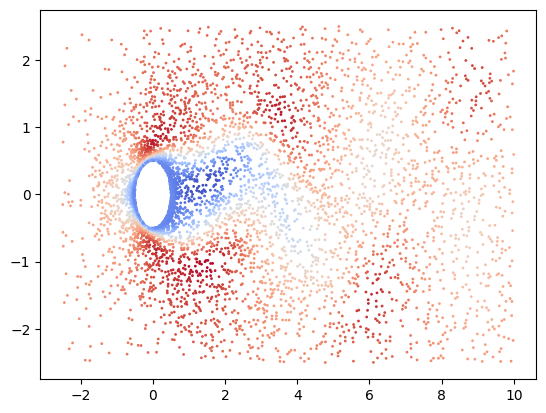

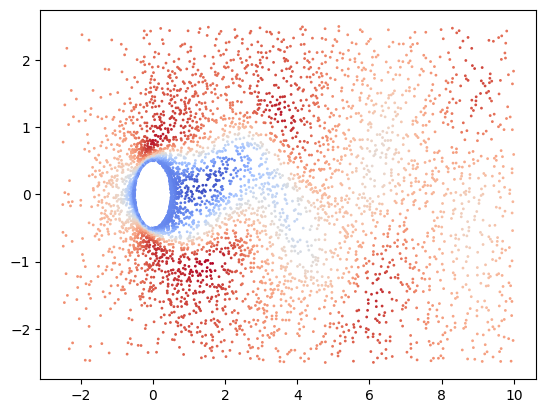

In [12]:
for i in range(100,102):
    plt.figure()
    plt.scatter(sub_X,sub_Y,c=U_nn[0,i], s=1, cmap = 'coolwarm')

In [ ]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,0], label = "Predicted")
    plt.plot(Phi_nn.cpu().numpy()[i,:,0], label = "DNS")
    plt.legend()

plt.ylabel("u0")
plt.xlabel("Timesteps")
plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")
plt.legend()

In [ ]:
for i in range (1):
    plt.figure()
    plt.plot(koop_out.cpu().numpy()[i,:,1], label = "Koopman Predicted")
    plt.plot(seqmodel_out.cpu().numpy()[i,:,1], label = "Seqmodel Predicted")
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,1], label = "DNS")
    plt.legend()

plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")
plt.legend()

In [14]:
#defining moving average
def moving_avg(u):

    pdu  = pd.DataFrame(u)
    u_ma = pdu.expanding().mean()
    return u_ma

# print(u_ma.shape)

# plt.plot(np.arange(u.shape[1]),u[...,0].squeeze(), label = "Mean Energy")
# plt.plot(u_ma)
# # plt.plot(np.arange(ref_X.shape[0]),ref_X_ma, linewidth = 3, label = "Time Moving Average")
# plt.xlabel("Time Units")
# plt.ylabel("Mean Energy")
# plt.legend()

In [13]:
Phi_nn_hat_ma = moving_avg(Phi_nn_hat.cpu().numpy())

plt.plot(Phi_nn_hat_ma)

NameError: name 'moving_avg' is not defined

In [58]:
#multistep prediction
timesteps = 40
initial_conditions = Phi_nn[:,0,:].to(eval_mza.device)
print(initial_conditions.shape)
x_hat, Phi_ms_hat     = eval_mza.predict_multistep(initial_conditions, timesteps)
U_ms_nn = Phi_ms_hat[...,:int(Phi_ms_hat.shape[-1]/2)].detach().cpu().numpy()
V_ms_nn = Phi_ms_hat[...,int(Phi_ms_hat.shape[-1]/2):].detach().cpu().numpy()
print(x_hat.shape, Phi_ms_hat.shape)


torch.Size([1, 10108])
torch.Size([1, 41, 2]) torch.Size([1, 41, 10108])


(41,)


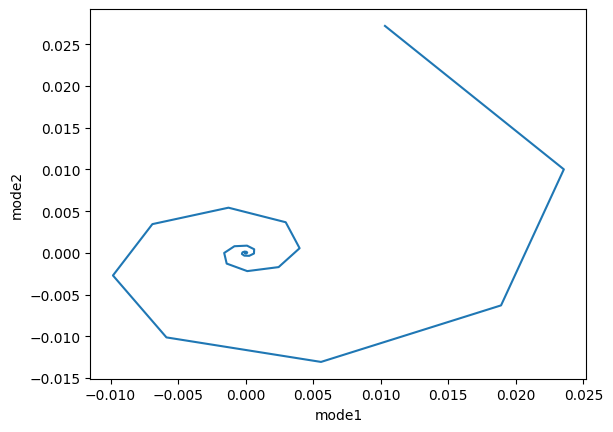

In [59]:
#2D Plots

data = x_hat.detach().cpu().numpy()
print(data[0,:,0].shape)
plt.plot(data[0,:,0],data[0,:,1])

plt.xlabel("mode1")
plt.ylabel("mode2")
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(data[0,:,0],data[0,:,1], data[0,:,2])

plt.show()



ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3, 201) and arg 2 with shape (201, 3).

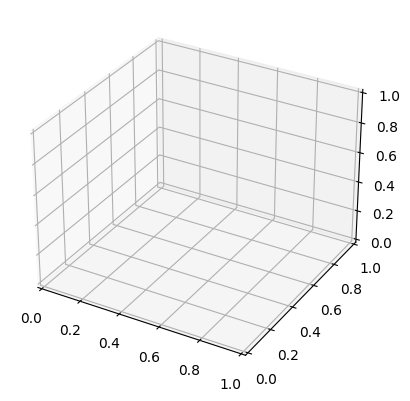

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate sample data
data = x_hat.detach().cpu().numpy()  # Replace with your actual data array

# Get x, y, and z coordinates
x = np.arange(data.shape[1])
y = np.arange(data.shape[2])
X, Y = np.meshgrid(x, y)
Z = data[0, :, :]

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [38]:
eval_mza.deactivate_seqmodel

False

In [39]:
# for i in range (1):
#     plt.figure()
#     plt.plot(Phi_nn.cpu().numpy()[i,:timesteps,0], '-', label = "Target")
#     plt.plot(Phi_hat.cpu().numpy()[i,:,0], '-', label = "Predicted")
#     plt.legend()



In [ ]:
for i in range(0,10):
    plt.figure()
    # plt.scatter(sub_X,sub_Y,c=U_ms_nn[0,i], s=1, cmap = 'coolwarm')
    plt.tricontour(sub_X,sub_Y,U_ms_nn[0,i], s=1, cmap = 'coolwarm')

In [33]:
print(Phi_nn.shape, Phi_ms_hat.shape)
State_MSE_multistep = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[:,:timesteps])
plt.figure()
plt.semilogy(State_MSE_multistep.detach().cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")

# np.save("koopman_numobs32.npy",Phi_hat.cpu().numpy())

torch.Size([1, 198, 10108]) torch.Size([1, 201, 10108])


/home/pg221/anaconda3/envs/KS/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 200, 10108])) that is different to the input size (torch.Size([1, 198, 10108])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (198) must match the size of tensor b (200) at non-singleton dimension 1

In [12]:
import numpy
k1 = np.load("koopman_numobs4.npy")
k2 = np.load("koopman_numobs16.npy")
k3 = np.load("koopman_numobs32.npy")
k1.shape

plt.figure()
# plt.plot(k1[:,0])
plt.plot(np.linspace(0,101,1001),k2[0,:,1], label = "Koopman")
plt.plot(np.linspace(0,101,1001),Phi_nn[0,:1001,1].cpu().numpy(), label = "Target")
plt.plot(np.linspace(0,101,1001),Phi_hat.cpu().numpy()[0,:,1], label = "MZA Memory = 0.4 timeunits")
# plt.plot(k3[:,0])
plt.legend()
plt.xlabel("Timeunits")
plt.ylabel("u1")
k2.shape

FileNotFoundError: [Errno 2] No such file or directory: 'koopman_numobs4.npy'

<Figure size 640x480 with 0 Axes>

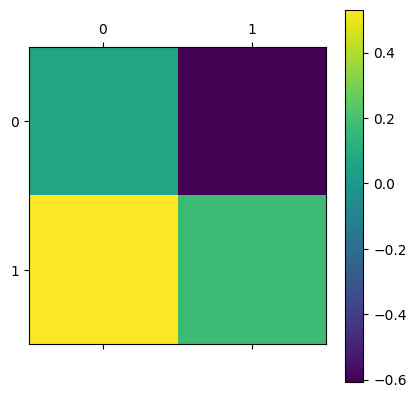

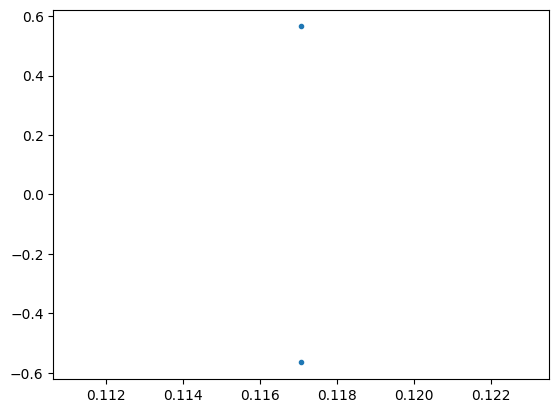

: 

In [24]:
mat = eval_mza.model.koopman.getKoopmanMatrix()
mat = mat.detach().cpu().numpy()
w, v = np.linalg.eig(mat)

idx = w.argsort()[::-1]
w = w[idx]
v = v[:,idx]

plt.figure()
plt.matshow(mat)
plt.colorbar()

plt.figure()
plt.plot(np.real(w), np.imag(w), ".")

In [50]:
print(v)

[[-0.6590989 +0.j         -0.6590989 -0.j         -0.5611127 +0.j
  -0.59986955+0.j         -0.59986955-0.j          0.0579122 +0.j
   0.10275634-0.21027166j  0.10275634+0.21027166j]
 [ 0.42595643+0.01296251j  0.42595643-0.01296251j  0.5531422 +0.j
  -0.21137244+0.12355813j -0.21137244-0.12355813j  0.61332333+0.j
  -0.01225696-0.02723885j -0.01225696+0.02723885j]
 [-0.15814564+0.06498217j -0.15814564-0.06498217j -0.39416677+0.j
  -0.11507002+0.08877631j -0.11507002-0.08877631j -0.09138632+0.j
   0.27734515+0.40742597j  0.27734515-0.40742597j]
 [ 0.09255031+0.01660752j  0.09255031-0.01660752j -0.14891446+0.j
  -0.23403145-0.0079724j  -0.23403145+0.0079724j   0.2149291 +0.j
   0.46631488-0.09011916j  0.46631488+0.09011916j]
 [ 0.47030097+0.00724845j  0.47030097-0.00724845j  0.29196602+0.j
  -0.27438274-0.38024306j -0.27438274+0.38024306j -0.33993784+0.j
  -0.0867408 -0.21926166j -0.0867408 +0.21926166j]
 [ 0.02160783-0.0422493j   0.02160783+0.0422493j  -0.00854447+0.j
  -0.13923292+0.316

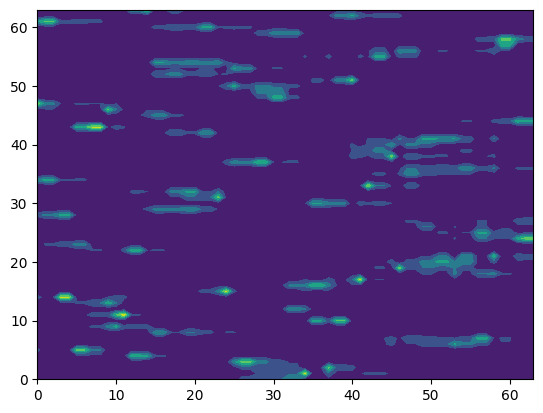

In [56]:
plt.contourf(abs(v))